In [1]:
import numpy as np
import os
from encoding import EncodingManager, create_encoding_dataloader
import encoding as encoding_module
import utils
from gan import Generator, Discriminator, train as train_gan
import gan as gan_module
import torch
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import ngram as ngram_module

/Users/johnhenryrudden/anaconda3/envs/shaky_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Error loading punkt: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>


In [2]:
BY_CHAR = True
TRAIN_PATH = 'data/raw_train.txt'
LOG_DIR_BASE = './runs/'
tokenized_sentences = utils.process_data(TRAIN_PATH, add_unks=not(BY_CHAR))
tokenized_sentences[:2]

[['First', 'Citizen', ':'],
 ['Before',
  'we',
  'proceed',
  'any',
  'further',
  ',',
  'hear',
  'me',
  'speak',
  '.']]

In [3]:
sentence_lengths = [len(sentence) for sentence in tokenized_sentences]
longest_sentence = max(tokenized_sentences, key=len)
avg_word_length = np.mean([len(word) for sentence in tokenized_sentences for word in sentence])
print(f'Longest sentence has {len(longest_sentence)} tokens')
SEQ_LENGTH = int(len(longest_sentence) * avg_word_length)

Longest sentence has 20 tokens


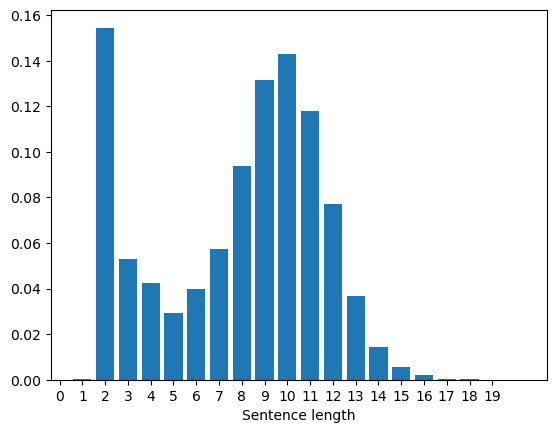

In [4]:
fraction_of_seq_lengths = {k: v / len(sentence_lengths) for k, v in Counter(sentence_lengths).items()}
plt.bar(fraction_of_seq_lengths.keys(), fraction_of_seq_lengths.values(), label='Seq Length distribution')
plt.xticks(np.arange(0, len(longest_sentence), 1))
plt.xlabel('Sentence length')
plt.savefig('./figs/seq_length_distribution.png')

In [5]:
tokenized_data = tokenized_sentences

# Encoding Dataloader checks

Double check one hot encoding and decoding is working as expected

In [6]:
ENCODING_MANAGER_PATH = 'data/word_to_index.json'
if BY_CHAR:
    ENCODING_MANAGER_PATH = 'data/char_to_index.json'
encoding_manager = EncodingManager(ENCODING_MANAGER_PATH)

keys loaded successfully from data/char_to_index.json


In [7]:
dataloader = create_encoding_dataloader(tokenized_data, encoding_manager, seq_length=SEQ_LENGTH, batch_size=4, by_char=True, verbose=True)
batch = next(iter(dataloader))
print(f'first batch sentence: {batch[0]}')
encoded_first_sentence = batch[0]
decoded_first_sentence = [encoding_manager.decode_one_hot(encoded_token) for encoded_token in encoded_first_sentence]
print(f'decoded first sentence: {decoded_first_sentence}')


Encoding sentence: ['W', 'e', ' ', 'h', 'a', 'v', 'e', ' ', 'l', 'e', 'd', ' ', 's', 'i', 'n', 'c', 'e', ' ', 't', 'h', 'y', ' ', 'e', 'x', 'i', 'l', 'e', ' ', '.', ' ', 'T', 'h', 'i', 'n', 'k', ' ', 'w', 'i', 't', 'h', ' ', 't', 'h', 'y', 's', 'e', 'l', 'f', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Encoding sentence: ['F', 'a', 'm', 'e', ' ', ',', ' ', 'a', 't', ' ', 't', 'h', 'e', ' ', 'w', 'h', 'i', 'c', 'h', ' ', 'h', 'e', ' ', 'a', 'i', 'm', 's', ' ', ',', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>',

In [8]:
# sentence_to_encode = ['That', 'you', 'have', "ta'en", 'a', 'tardy', '<UNK>', 'here', '.', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
# encoded_sentence = [word2vec_manager.one_hot_encode(word) for word in sentence_to_encode]
# decoded = [word2vec_manager.decode_one_hot(one_hot) for one_hot in encoded_sentence]
# encoded_sentence,decoded

# Start model training

In [9]:
# Initialize models
seq_length = SEQ_LENGTH 

# Generator first

gen_input_dim = len(encoding_manager.word_to_index) + 1 # add 1 to input dim to account for padding token
gen_hidden_dim = 300

# add 1 to output dim to account for padding token
gen_output_dim = len(encoding_manager.word_to_index) + 1

generator = Generator(input_size=gen_input_dim, hidden_size=gen_hidden_dim, output_size=gen_output_dim, seq_length=seq_length)


# Discriminator
# Discriminator input is the same as the generator output (the generated next token probability distribution)
discrim_input_dim = gen_output_dim
discrim_hidden_dim = 100

discriminator = Discriminator(input_dim=discrim_input_dim, hidden_dim=discrim_hidden_dim, seq_length=seq_length)

In [10]:
discrim_params = list(discriminator.parameters())
gen_params = list(generator.parameters())
num_params_gen = sum([np.prod(p.size()) for p in gen_params])
num_params_discrim = sum([np.prod(p.size()) for p in discrim_params])
print(f'Generator has {num_params_gen} parameters')
print(f'Discriminator has {num_params_discrim} parameters')

Generator has 461466 parameters
Discriminator has 67301 parameters


In [11]:
# Train models

# Hyperparameters
learning_rate = 0.0001
batch_size = 4
temperature = 1.0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 1
TRAIN_AND_VAL_FRAC = 0.5
if TRAIN_AND_VAL_FRAC != 1.0:
    train_val, rest = train_test_split(tokenized_data, train_size=TRAIN_AND_VAL_FRAC, random_state=42)
    train_set, val_set = train_test_split(train_val, train_size=0.8, random_state=42)
else:
    train_set, val_set = train_test_split(tokenized_data, train_size=0.9, random_state=42)



In [12]:
def generate_sentences(generator, temp):
    gens = []
    for i in range(10):
        noise = torch.randn(1, seq_length, gen_input_dim)
        generated_data = generator(noise, temperature, hard=False)
        argmaxs = torch.argmax(generated_data[0], dim=1)
        generated_sentence = [encoding_manager.index_to_word(index) for index in argmaxs]
        gens.append(" ".join(generated_sentence).replace("<PAD>", ""))
    return gens

In [13]:
def test_hyperparams(possible_hyperparams, num_epochs, train_set, val_set, encoding_manager, metrics_dir, calc_perplexity):
    assert len(possible_hyperparams.keys()) == 3 and set(possible_hyperparams.keys()) == set(['lr', 'temp', 'batch_size'])
    num_iterations = np.prod([len(possible_hyperparams[key]) for key in possible_hyperparams.keys()])
    current_iteration = 0
    results = []
    for lr in possible_hyperparams['lr']:
        for temp in possible_hyperparams['temp']:
            for batch_size in possible_hyperparams['batch_size']:
                current_iteration += 1
                print(f'Iteration {current_iteration} of {num_iterations}')
                print(f'lr={lr}, temp={temp}, batch_size={batch_size}, seq_length={seq_length}')
                generator = Generator(input_size=gen_input_dim, hidden_size=gen_hidden_dim, output_size=gen_output_dim, seq_length=seq_length)
                discriminator = Discriminator(input_dim=discrim_input_dim, hidden_dim=discrim_hidden_dim, seq_length=seq_length)
                g_loss, d_loss =train_gan(
                        generator=generator,
                        discriminator=discriminator,
                        generator_lr = lr,
                        discriminator_lr = lr,
                        validation_sentences=val_set,
                        training_sentences=train_set,
                        word_encoding_manager=encoding_manager,
                        calc_perplexity=calc_perplexity,
                        seq_length=SEQ_LENGTH,
                        generator_input_features=gen_input_dim,  # Updated parameter name
                        num_epochs=num_epochs,
                        batch_size=batch_size,
                        noise_sample_method="normal",
                        gumbel_hard=True,
                        temperature=temp,
                        device=device,
                        by_char=BY_CHAR,
                        tensorboard_log_dir=metrics_dir
                    )
                gens = generate_sentences(generator, temp)
                results.append((lr, temp, batch_size, seq_length, g_loss, d_loss, generator, discriminator, gens))
                print(f'Generated sentences: {gens[:2]}')
    return results
              

In [14]:
# ngram_for_perplexity = ngram_module.NGRAM_Model(4, scoring_method='LI_grid_search')
# ngram_for_perplexity.train(train_set)

In [15]:
# TODO: fix NGRAM to work with chars
# calc_perplexity = lambda sentences: gan_module.estimate_perplexity(sentences, ngram_for_perplexity)
calc_perplexity = lambda sentences: float('inf')

In [16]:
import shutil
def prepare_metrics_dir(log_dir):
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    else:
        # clear existing logs
        for f in os.listdir(log_dir):
            if os.path.isdir(os.path.join(log_dir, f)):
                shutil.rmtree(os.path.join(log_dir, f))
            else:
                os.remove(os.path.join(log_dir, f))

def run_experiment(possible_hyperparams, experiment_id, num_epochs, train_set, val_set, encoding_manager, calc_perplexity, log_dir_base):
    log_dir = os.path.join(log_dir_base, "hyperparameter_search_" + experiment_id)
    prepare_metrics_dir(log_dir)
    results = test_hyperparams(possible_hyperparams, num_epochs, train_set, val_set, encoding_manager, log_dir, calc_perplexity)          
    return results

In [17]:
possible_hyperparams = {
        'lr': [0.0001],
        'batch_size': [32],
        'temp': [1.0],
        # 'seq_length': [15],
    }

test_results = run_experiment(possible_hyperparams, "test", num_epochs, train_set, val_set, encoding_manager, calc_perplexity, LOG_DIR_BASE)

Iteration 1 of 1
lr=0.0001, temp=1.0, batch_size=32, seq_length=71


Epoch 1/1:   0%|          | 0/366 [00:00<?, ?it/s]

Epoch 1/1 | Generator Loss: 0.6950 | Discriminator Loss: 1.3863: 100%|██████████| 366/366 [06:49<00:00,  1.12s/it]

Generated sentences: ['r x b I N  u                                                                ', 'F 3 , 3 I j t                                                                ']


In [18]:
test_results

[(0.0001,
  1.0,
  32,
  71,
  0.6758459619159907,
  1.3740535687879134,
  Generator(
    (lstm): LSTM(66, 300, batch_first=True)
    (fc): Linear(in_features=300, out_features=66, bias=True)
    (ls): LogSoftmax(dim=2)
  ),
  Discriminator(
    (lstm): LSTM(66, 100, batch_first=True)
    (fc): Linear(in_features=100, out_features=1, bias=True)
  ),
  ['r x b I N  u                                                                ',
   'F 3 , 3 I j t                                                                ',
   '- y  . n Q Y                                                                ',
   '. Z m u N N   m                                                              ',
   'e j G B K !   ? v                                                              ',
   "' P J n P x f  u n d                                                            ",
   'Z ! u   p x  q                                                              ',
   'j Q n 3 - c  n  n                                     

In [19]:
assert False # don't run this cell again

AssertionError: 

In [ ]:
BEST_BATCH_MODEL_PATH = './models/generator_batch_size_4.pt'
if os.path.exists(BEST_BATCH_MODEL_PATH):
    generator = gan_module.load_gen_model(BEST_BATCH_MODEL_PATH, gen_input_dim, gen_hidden_dim, gen_output_dim, seq_length)
    batch_size_results = [(0.001, 1.0, 4, 15, 0.0, 0.0, generator, None, generate_sentences(generator, 1.0))]
else:
    possible_hyperparams = {
        'lr': [0.001],
        'batch_size': [4, 16, 32],
        'temp': [1.0],
        'seq_length': [15],
    }
    batch_size_results = run_experiment(possible_hyperparams, "batch_size", num_epochs, train_sents, val_sents, encoding_manager, calc_perplexity, LOG_DIR_BASE)

In [ ]:
batch_size_results

In [ ]:
BEST_SEQ_LENGTH_MODEL_PATH = './models/generator_seq_length_13.pt'
if os.path.exists(BEST_SEQ_LENGTH_MODEL_PATH):
    generator = gan_module.load_gen_model(BEST_SEQ_LENGTH_MODEL_PATH, gen_input_dim, gen_hidden_dim, gen_output_dim, seq_length)
    seq_length_results = [(0.001, 1.0, 4, 13, 0.0, 0.0, generator, None, generate_sentences(generator, 1.0))]
else:
    possible_hyperparams = {
        'lr': [0.001],
        'batch_size': [16],
        'temp': [1.0],
        'seq_length': [13,15],
    }
    seq_length_results = run_experiment(possible_hyperparams, "seq_length", num_epochs, train_sents, val_sents, encoding_manager, calc_perplexity, LOG_DIR_BASE)


In [ ]:
seq_length_results

In [ ]:
BEST_TEMP_MODEL_PATH = './models/generator_temp_1.0.pt'
if os.path.exists(BEST_TEMP_MODEL_PATH):
    generator = gan_module.load_gen_model(BEST_TEMP_MODEL_PATH, gen_input_dim, gen_hidden_dim, gen_output_dim, seq_length)
    temp_results = [(0.001, 1.0, 4, 15, 0.0, 0.0, generator, None, generate_sentences(generator, 1.0))]
else:
    possible_hyperparams = {
        'lr': [0.001],
        'batch_size': [16],
        'temp': [1.0, 1.5],
        'seq_length': [15],
    }

    temp_results = run_experiment(possible_hyperparams, "temp", num_epochs, train_sents, val_sents, encoding_manager, calc_perplexity, LOG_DIR_BASE)

In [ ]:
temp_results

In [ ]:
BEST_LR_MODEL_PATH = './models/generator_lr_0.0001.pt'
if os.path.exists(BEST_LR_MODEL_PATH):
    generator = gan_module.load_gen_model(BEST_LR_MODEL_PATH, gen_input_dim, gen_hidden_dim, gen_output_dim, seq_length)
    lr_results = [(0.0001, 1.0, 16, 15, 0.0, 0.0, generator, None, generate_sentences(generator, 1.0))]
else:
    possible_hyperparams = {
        'lr': [0.0001],
        'batch_size': [16],
        'temp': [1.0],
        'seq_length': [15],
    }

    lr_results = run_experiment(possible_hyperparams, "lr", num_epochs, train_sents, val_sents, encoding_manager, calc_perplexity, LOG_DIR_BASE)

In [ ]:
lr_results

In [ ]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

In [ ]:
DISCRIM_LOSS_CSV_PATH = 'metrics/Loss _ Train_Discriminator Loss.csv'
GEN_LOSS_CSV_PATH = 'metrics/Loss _ Train_Generator Loss.csv'
GAN_LOSS_PLOT_PATH = 'figs/gan_loss_plot.png'

import pandas as pd
discrim_loss_df = pd.read_csv(DISCRIM_LOSS_CSV_PATH)
gen_loss_df = pd.read_csv(GEN_LOSS_CSV_PATH)

window_size = 40

smoothed_discrim_loss = moving_average(discrim_loss_df['Value'], window_size)
smoothed_gen_loss = moving_average(gen_loss_df['Value'], window_size)


plt.plot(discrim_loss_df['Step'], discrim_loss_df['Value'], alpha=0.2, c='#e52592')
plt.plot(gen_loss_df['Step'], gen_loss_df['Value'], alpha=0.2, c='#12b5cb')
plt.plot(discrim_loss_df['Step'][:-(window_size - 1)], smoothed_discrim_loss, label='Discriminator loss', c='#e52592')
plt.plot(gen_loss_df['Step'][:-(window_size - 1)], smoothed_gen_loss, label='Generator loss', c='#12b5cb')
plt.xlabel('Batch #')
plt.ylabel('Loss')
plt.title('GAN Loss')
# log scale
plt.legend()

plt.savefig(GAN_LOSS_PLOT_PATH)

In [ ]:
# now plot perplexity
PERPLEXITY_CSV_PATH = 'metrics/perplexity.csv'
perplexity_df = pd.read_csv(PERPLEXITY_CSV_PATH)
plt.plot(perplexity_df['Step'], perplexity_df['Value'], alpha=0.9, c='#e52592')
plt.xlabel('Batch #')
plt.ylabel('Mean Perplexity')
#log scale
plt.title('GAN Perplexity')
plt.yscale('log')
plt.savefig('figs/gan_perplexity_plot1.png')
# log scale

In [ ]:
 possible_hyperparams = {
        'lr': [0.0001],
        'batch_size': [16],
        'temp': [1.0],
        'seq_length': [15],
    }

lr_results = run_experiment(possible_hyperparams, "lr", num_epochs, train_sents, val_sents, encoding_manager, calc_perplexity, LOG_DIR_BASE)